Training size: 4200
Testing size: 1800
Epoch 1/10, Train Loss: 0.5342, Train Accuracy: 0.7883, Test Accuracy: 0.8578
Epoch 2/10, Train Loss: 0.3306, Train Accuracy: 0.8760, Test Accuracy: 0.8528
Epoch 3/10, Train Loss: 0.2487, Train Accuracy: 0.9026, Test Accuracy: 0.9261
Epoch 4/10, Train Loss: 0.2325, Train Accuracy: 0.9076, Test Accuracy: 0.8644
Epoch 5/10, Train Loss: 0.2374, Train Accuracy: 0.9117, Test Accuracy: 0.8900
Epoch 6/10, Train Loss: 0.1414, Train Accuracy: 0.9536, Test Accuracy: 0.9489
Epoch 7/10, Train Loss: 0.1241, Train Accuracy: 0.9550, Test Accuracy: 0.9589
Epoch 8/10, Train Loss: 0.1108, Train Accuracy: 0.9590, Test Accuracy: 0.9617
Epoch 9/10, Train Loss: 0.1081, Train Accuracy: 0.9610, Test Accuracy: 0.9672
Epoch 10/10, Train Loss: 0.1118, Train Accuracy: 0.9593, Test Accuracy: 0.9606


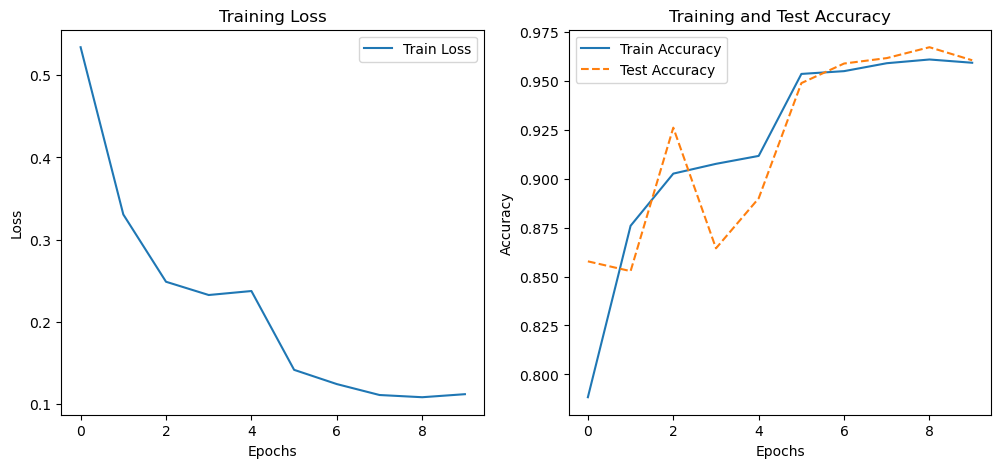

c:\Users\Anna\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Anna\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Anna\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Anna\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Anna\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(

Output shape from the model: (1800, 3)


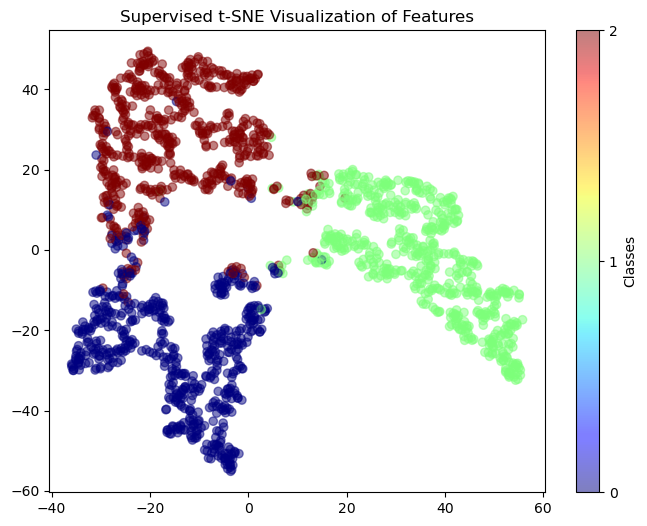

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = './Dataset 1/Colorectal Cancer'
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split dataset into 70% training, 30% testing
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training size: {train_size}")
print(f"Testing size: {test_size}")


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


num_epochs = 10
train_loss_history, train_acc_history, test_acc_history = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    scheduler.step()
    
    # Evaluate on test data
    model.eval()  
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    test_acc_history.append(test_acc)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

# Plot training and test accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(test_acc_history, label="Test Accuracy", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()
plt.show()


def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.cpu().numpy())
    
    return np.concatenate(features), np.concatenate(labels)


features, feature_labels = extract_features(model, test_loader)


scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


classifier = LogisticRegression(max_iter=1000)
classifier.fit(features_scaled, feature_labels)


tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=None)
features_tsne = tsne.fit_transform(features_scaled)
print("Output shape from the model:", features.shape)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=feature_labels, cmap="jet", alpha=0.5)
plt.colorbar(scatter, ticks=np.unique(feature_labels), label="Classes")
plt.title("Supervised t-SNE Visualization of Features")
plt.show()
